# Washington, DC Cherry Blossom Prediction 

In [ ]:
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
temps_path = Path("Data/full_temps_dc.csv")
temps = pd.read_csv(temps_path)

temps['date'] = pd.to_datetime(temps['date'])
temps['year'] = temps['date'].dt.year
temps["month"] = temps["date"].dt.month

temps["season_year"] = temps['year']
temps.loc[temps['month'] >= 10, "season_year"] += 1

bloom_path = Path("Data/blooms_dc.csv")
bloom= pd.read_csv(bloom_path)
bloom = bloom[bloom['year'] > 1942]
bloom['date'] = pd.to_datetime(bloom['bloom_date'])
bloom['doy'] = bloom['date'].dt.dayofyear

temps['date'] = pd.to_datetime(temps['date'])
temps['tavg'] = (temps['tmin'] + temps['tmax']) / 2
temps['doy'] = temps['date'].dt.dayofyear

## Simulation Function
This function first accumulates chill daily. When the chill threshold is met it starts accumulating heat. Function stops when heat accumulation reaches GDD requirment. The day the function stops is the predicted bloom DOY.

In [3]:
def simulate_bloom_year(temps, bloom_year,
                        chill_threshold,
                        GDD_req,
                        chill_base=7.2,
                        gdd_base=4.4):
    
    df = temps[temps["season_year"] == bloom_year].copy()
    df = df.sort_values("date")

    chill_cum = 0
    chill_met = False
    chill_date = None

    for _, row in df.iterrows():
        if row['tavg'] < chill_base:
            chill_cum += 1
        if chill_cum >= chill_threshold:
            chill_met = chill_date = row["date"]
            break
    
    if not chill_met:
        return None
    
    GDD_df = df[df['date'] >= chill_date]
    GDD_cum = 0

    for _, row in GDD_df.iterrows():
        GDD_cum += max(row['tavg'] - gdd_base, 0)
        if GDD_cum >= GDD_req:
            return row['doy']
        
    return None

## Estimating GDD Requirment From Historical Bloom Dates

This function finds the chill release date for each historical year, and calculates the total GDD from actual bloom. It averages those GDD values and that average becomes the GDD requirement. 

In [4]:
def estimate_GDD_requirement(
        temps, bloom_df,
        chill_threshold,
        chill_base=7.2,
        gdd_base=4.4):

    GDD_values = []

    for year in bloom_df["year"]:

        df = temps[temps["season_year"] == year].copy()
        df = df.sort_values("date")

        bloom_doy = bloom_df.loc[
            bloom_df["year"] == year, "bloom_doy"
        ].values[0]

        df["is_chill"] = df["tavg"] < chill_base
        df["gdd"] = np.maximum(df["tavg"] - gdd_base, 0)

        chill_cum = 0
        chill_met = False
        GDD_cum = 0

        for _, row in df.iterrows():

            if not chill_met:
                chill_cum += row["is_chill"]
                if chill_cum >= chill_threshold:
                    chill_met = True

            elif row["doy"] <= bloom_doy:
                GDD_cum += row["gdd"]

            else:
                break

        if chill_met:
            GDD_values.append(GDD_cum)

    if len(GDD_values) == 0:
        return None

    return np.mean(GDD_values)

## Threshold Model Evaluation

In [5]:
def evaluate_threshold(temps, bloom_df, chill_threshold):

    GDD_req = estimate_GDD_requirement(
        temps, bloom_df, chill_threshold
    )

    if GDD_req is None:
        return None, None, None

    predictions = []
    actuals = []

    for year in bloom_df["year"]:

        pred = simulate_bloom_year(
            temps,
            year,
            chill_threshold,
            GDD_req
        )

        if pred is not None:
            predictions.append(pred)
            actuals.append(
                bloom_df.loc[
                    bloom_df["year"] == year, "bloom_doy"
                ].values[0]
            )

    if len(predictions) == 0:
        return None, None, None

    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    return mae, r2, GDD_req

## Grid Search for Optimal Chill Threshold
Estimating chill threshold using GDD multiplier gird. Without grid search, the GDD requirment would just be the mean heat accumulation, which makes the GDD requirment fixed. 

In [6]:
results = []

for t in range(40, 120):  
    mae, r2, GDD_req = evaluate_threshold(temps, bloom, t)

    if mae is None:
        continue

    results.append((t, mae, r2, GDD_req))

results_df = pd.DataFrame(
    results,
    columns=["chill_threshold", "mae", "r2", "GDD_requirement"]
)

best_row = results_df.loc[results_df["mae"].idxmin()]

print(best_row)

chill_threshold     54.000000
mae                  3.024390
r2                   0.628915
GDD_requirement    204.453049
Name: 14, dtype: float64


This optimizer says cherry tress in DC require  approximately 54 chill days (<7.2°C). Then approximately 204 growing degree days (4.4°C base), for peak bloom to occur. 

A huge jump in $R^2$ compared to previous model. 


## Optimized Model

In [7]:
best_threshold = int(best_row["chill_threshold"])
best_GDD = best_row["GDD_requirement"]

predictions = []
actuals = []

for year in bloom["year"]:
    
    pred = simulate_bloom_year(
        temps,              
        year,             
        best_threshold,
        best_GDD
    )
    
    if pred is not None:
        predictions.append(pred)
        actuals.append(
            bloom.loc[
                bloom["year"] == year, "bloom_doy"
            ].values[0]
        )

print("Final MAE:", mean_absolute_error(actuals, predictions))
print("Final R²:", r2_score(actuals, predictions))

Final MAE: 3.024390243902439
Final R²: 0.6289150332735243


Model predictions are off by about ±3 days. 

### Optimization Plot

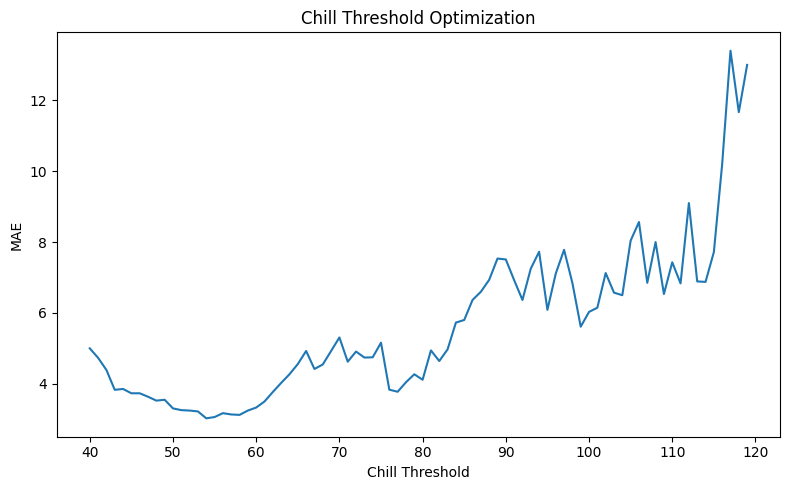

In [8]:
plt.figure(figsize=(8, 5))

plt.plot(results_df["chill_threshold"], results_df["mae"])

plt.xlabel("Chill Threshold")
plt.ylabel("MAE")
plt.title("Chill Threshold Optimization")

plt.tight_layout()
plt.show()

### Rolling Origin Cross-Validation
A time-series cross-validation technique where the model trains on a sequential window of time, tested on the subsequent period, and the window rolls to include new intervals for subsequent iterations. Bloon timing is time-depeendent and climate trend, more so than ever, matter. This mimics what real forecasting has shown, while preventing overfitting and accidental leakage.

In [9]:
cv_results = []

years = sorted(bloom["year"].unique())

for t in range(40, 120):
    errors = []

    for i in range(10, len(years)):
        train_years = years[:i]
        test_year = years[i]
        gdd_list = []

        for y in train_years:
            actual_doy = bloom.loc[bloom["year"] == y, "doy"].values[0]
            df_year = temps[temps["season_year"] == y].sort_values("date")
            chill, gdd = 0, 0

            for _, row in df_year.iterrows():
                if chill < t:
                    if row["tavg"] < 7.2:
                        chill += 1
                else:
                    if row["doy"] <= actual_doy:
                        gdd += max(0, row["tavg"] - 4.4)
                    else:
                        break

            gdd_list.append(gdd)

        if len(gdd_list) == 0:
            continue

        GDD_req_train = np.mean(gdd_list)
        pred = simulate_bloom_year(temps, test_year, t, GDD_req_train)

        if pred is not None:
            actual = bloom.loc[bloom["year"] == test_year, "doy"].values[0]
            errors.append(pred - actual)

    if len(errors) == 0:
        continue

    errors = np.array(errors)
    cv_results.append((t, np.mean(np.abs(errors)), np.mean(errors)))

cv_results_df = pd.DataFrame(cv_results, columns=["chill_threshold", "cv_mae", "cv_bias"])
best_row = cv_results_df.loc[cv_results_df["cv_mae"].idxmin()]

print(f"  Best Chill Threshold:  {int(best_row['chill_threshold'])} days")
print(f"  Cross-Validated MAE:   {best_row['cv_mae']:.2f} days")
print(f"  Mean Bias:             {best_row['cv_bias']:.2f} days")


  Best Chill Threshold:  54 days
  Cross-Validated MAE:   3.19 days
  Mean Bias:             0.33 days


Model got slightly worse, but is an almost negligable differece. 
meaning original evaluation was overfitting. This is likely due estimating GDD_req across all years including the yest year, so the model had the answer partially.

### GDD Requirement using All Historical Years

In [ ]:
gdd_all = []

for y in bloom["year"]:

    actual_doy = bloom.loc[bloom["year"] == y, "doy"].values[0]

    df_year = temps[temps["season_year"] == y].copy()
    df_year = df_year.sort_values("date")

    chill = 0
    gdd = 0

    for _, row in df_year.iterrows():

        if chill < best_threshold:
            if row["tavg"] < 7.2:
                chill += 1
        else:
            if row["doy"] <= actual_doy:
                gdd += max(0, row["tavg"] - 4.4)
            else:
                break

    gdd_all.append(gdd)

best_GDD_full = np.mean(gdd_all)

print("Final GDD Requirement:", best_GDD_full)

Final GDD Requirement: 201.9897590361446


## Diagnostics

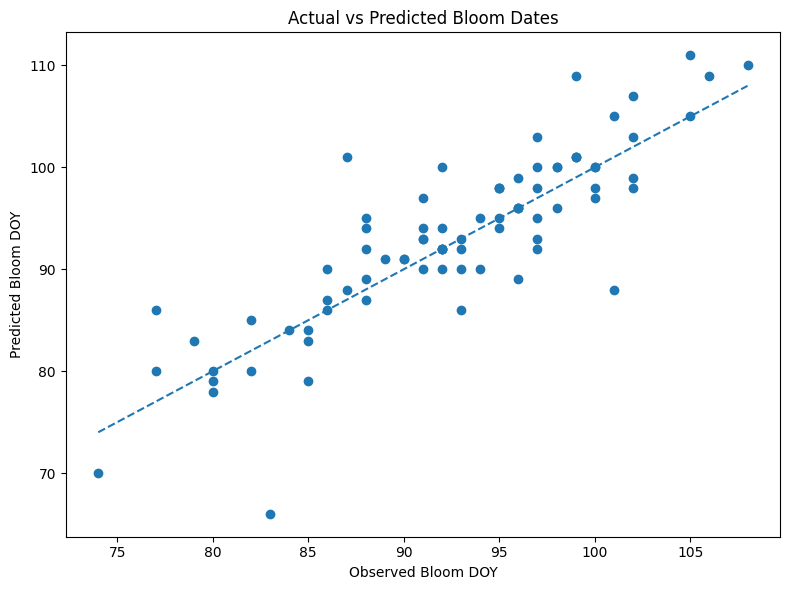

In [11]:
plt.figure(figsize=(8, 6))

plt.scatter(actuals, predictions)
plt.plot(
    [min(actuals), max(actuals)],
    [min(actuals), max(actuals)],
    linestyle='--'
)

plt.xlabel("Observed Bloom DOY")
plt.ylabel("Predicted Bloom DOY")
plt.title("Actual vs Predicted Bloom Dates")

plt.tight_layout()
plt.show()

A strong linear trend with some outliers. 

### Residuals vs Year

In [12]:
residuals = np.array(predictions) - np.array(actuals)

# plt.figure(figsize=(10, 5))
# plt.scatter(bloom["year"], residuals)

# plt.axhline(0, linestyle='--')

# plt.xlabel("Year")
# plt.ylabel("Prediction Error (Days)")
# plt.title("Model Residuals Over Time")

# plt.tight_layout()
# plt.show()

### Error Distribution

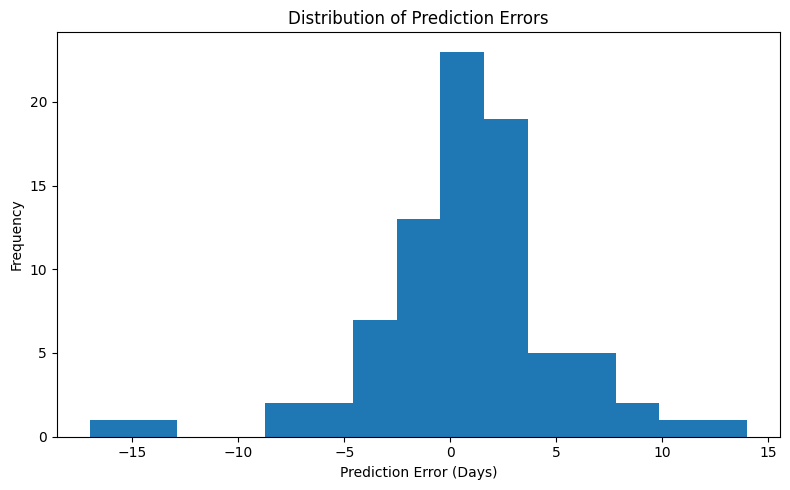

In [13]:
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=15)

plt.xlabel("Prediction Error (Days)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")

plt.tight_layout()
plt.show()

Approximately normally distribued, but an interesting negative outlier. 

### Stability Plot 

In [14]:
# abs_errors = np.abs(residuals)

# plt.figure(figsize=(10, 5))
# plt.plot(bloom["year"], abs_errors)

# plt.xlabel("Year")
# plt.ylabel("Absolute Error (Days)")
# plt.title("Absolute Prediction Error Over Time")

# plt.tight_layout()
# plt.show()

## 2026 Predictions

In [15]:
temps_2026_path = Path("Data/dc_temps_2026.csv")
temps_2026 = pd.read_csv(temps_2026_path)
temps_2026['date'] = pd.to_datetime(temps_2026['date'])
temps_2026["month"] = temps_2026["date"].dt.month

temps_2026["season_year"] = np.where(
    temps_2026["month"] >= 10,
    temps_2026["year"] + 1,
    temps_2026["year"]
)


In [16]:
prediction_2026 = simulate_bloom_year(
    temps_2026,
    2026,
    best_threshold,
    best_GDD_full
)

print("Washington, DC 2026 Prediction: ", prediction_2026)

Washington, DC 2026 Prediction:  93


April 3rd is the predicted peak bloom date for 2026. 

## Bootstrap Prediction Intervals 
Under constuction...